### Librerías que se utilizan:

In [26]:
import numpy as np
import sympy as sym
import matplotlib.pyplot as plt
import pyvista as pv
import meshio

# 3. Integración 1D
#### Integral:
$$\int \limits_{0}^{8}\left(sin^2(\pi x) + cos(x)\right)dx$$

Funciones para la integración numérica con el método de Cuadratura Gaussiana: 

In [27]:
def numerical_integration_1D(xa, xb, f, n):
    points, wi = np.polynomial.legendre.leggauss(n)
    
    m = (xb-xa)/2
    xi = m*points + m+xa

    yi = sym.lambdify(x, f)(xi)
    area = (xb-xa)*sum(wi*yi)/2
    return area

def segmented_1D_numerical_integration(la, lb, n, f):
    xn = np.linspace(la, lb, n+1)

    integral = 0
    for j in range(n):
        xa = xn[j]
        xb = xn[j+1]

        area = numerical_integration_1D(xa, xb, f, 2)
        integral += area
    return integral

Solución analítica:

In [28]:
x = sym.Symbol('x')
f = (sym.sin(sym.pi*x))**2 + sym.cos(x)

la, lb = (0, 8)

analyticalIntegral = round(sym.integrate(f, (x, la, lb)),5)
print('Integral real: ', round(analyticalIntegral,5))

Integral real:  4.98936


Integración para el dominio subdividido n segmentos y en cada uno de ellos se utiliza 2 puntos de
cuadratura y luego se suma el resultado; Integración en todo el dominio utilizando n puntos de cuadratura; Y comparacion del el error relativo de los dos métodos.

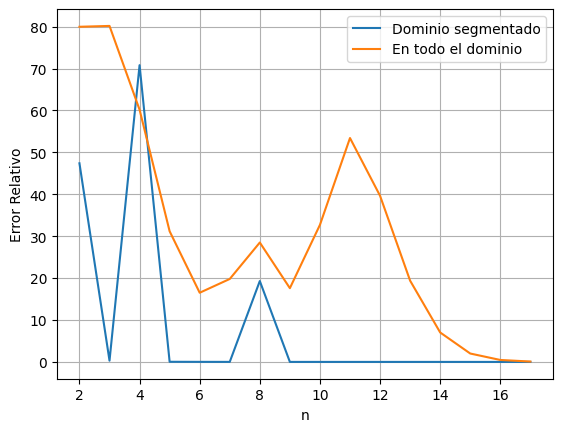

In [29]:
n = 17

n_Integrals_SegmentedDomain = []
n_Integrals_FullDomain = []
errorR_SegmentedDomain = []
errorR_FullDomain = []

ns = np.arange(2, n+1, 1)

for n in ns:
    integral = segmented_1D_numerical_integration(la, lb, n, f)
    n_Integrals_SegmentedDomain.append(integral)
    errorR_SegmentedDomain.append(round(100*abs(integral-analyticalIntegral)/analyticalIntegral,3))
    
    integral = numerical_integration_1D(la, lb, f, n)
    n_Integrals_FullDomain.append(integral)
    errorR_FullDomain.append(round(100*abs(integral-analyticalIntegral)/analyticalIntegral,3))

plt.figure()
plt.plot(ns, errorR_SegmentedDomain, label = "Dominio segmentado")
plt.plot(ns, errorR_FullDomain, label = "En todo el dominio")
plt.grid()
plt.xlabel("n")
plt.ylabel("Error Relativo")
plt.legend()

# 4. Mallas e Integración 2D
#### Integral:
$$\iint \limits_{\Omega} \left(sin(\pi x) \cdot cos^2(\pi y)\right) d\Omega$$
#### Dominio: 
$$\Omega = \left\lbrace 0, 5 \right\rbrace \times \left\lbrace 0, 2 \right\rbrace \ \cup \ \left\lbrace 2, 7 \right\rbrace \times \left\lbrace 2, 4 \right\rbrace$$

#### Solución analítica:
$$\int \limits_{0}^{2} \int \limits_{0}^{5} \left(sin(\pi x) \cdot cos^2(\pi y)\right) \, dx \, dy + \int \limits_{2}^{4} \int \limits_{2}^{7} \left(sin(\pi x) \cdot cos^2(\pi y)\right) \, dx \, dy$$

In [30]:
x, y = sym.symbols('x y')
f = sym.sin(sym.pi*x)*sym.cos(sym.pi*y)**2

xla1, xlb1 = (0, 5)
xla2, xlb2 = (2, 7)
yla1, ylb1 = (0, 2)
yla2, ylb2 = (2, 4)

analyticalIntegral = round(sym.integrate(f, (y, yla1, ylb1), (x, xla1, xlb1)) + sym.integrate(f, (y, yla2, ylb2), (x, xla2, xlb2)),7)
print('Integral analítica: ', analyticalIntegral)

Integral analítica:  1.2732395


Para la integración 2D con el Método de Cuadraturas Gaussianas se hace uso de la función ***gaussian_integration_2D*** creada por **© Daniel Giraldo Cuartas 2022**:

In [31]:
def gaussian_integration_2D(p0, p1, p2, p3, fun, nx, ny):
    '''
        - p0, p1, p2, p3:
            Coordenadas de los punto (x,y) del cuadrilatero
        
        - fun:
            Funcion lambda f(x,y) a interpolar
            
        - nx, ny:
            Numero de puntos de cuadratura a utilizar en direccion
            x, y respectivamente.
    '''
    xi, wi = np.polynomial.legendre.leggauss(nx)
    yj, wj = np.polynomial.legendre.leggauss(ny)
    
    X = np.matrix([p0, p1, p2, p3])
    
    
    Nt = lambda r,s : 0.25*np.array([
        (1-r)*(1-s),
        (1+r)*(1-s),
        (1+r)*(1+s),
        (1-r)*(1+s)
        ])
    
    Dt = lambda r,s : 0.25*np.array([
        [s-1, r-1],
        [1-s, -1-r],
        [1+s, 1+r],
        [-1-s, 1-r]
        ]).transpose()
    
    integral = 0
    for i in range(nx):
        rx = xi[i]
        wx = wi[i]
        for j in range(ny):
            sy = yj[j]
            wy = wj[j]
            
            J = Dt(rx, sy)*X
            det_J = np.linalg.det(J)
            
            x_vec = Nt(rx, sy)*X
            f_val = fun(x_vec[0,0], x_vec[0,1])
            integral += (f_val)*det_J*wx*wy
            
    return integral

El dominio de integracion $\Omega$ corresponde al mostrado en la siguiente figura. Para almacenar este dominio, se hace una malla con dos rectangulos apartir de los puntos dados.  

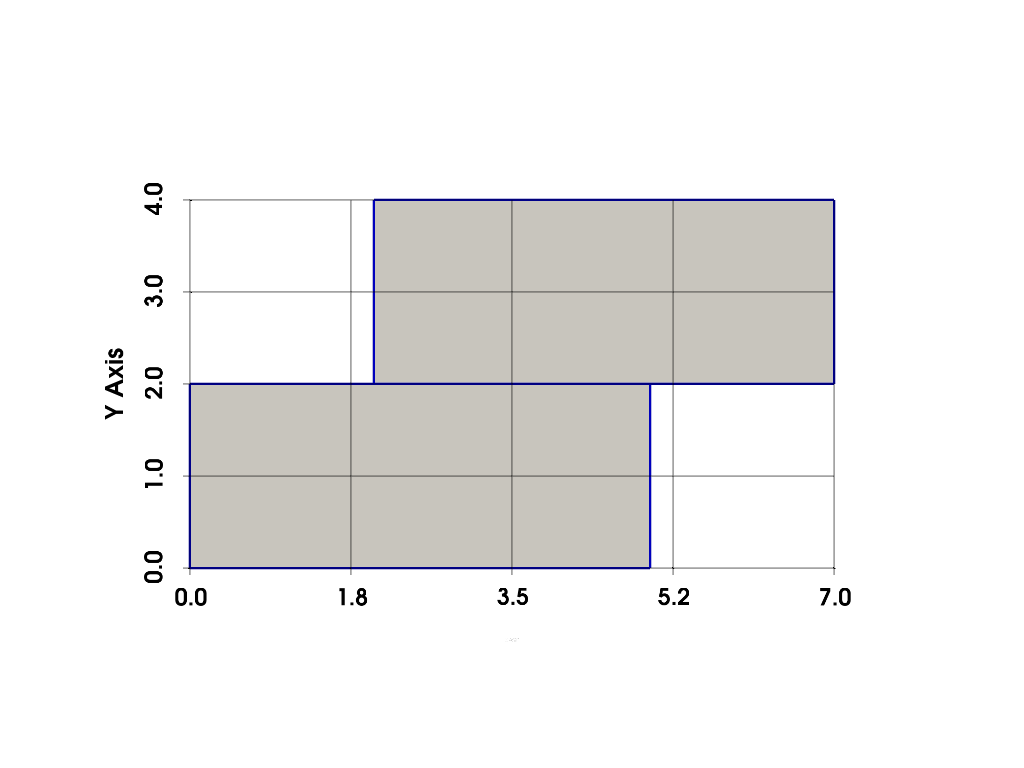

In [32]:
points = np.array([
    [0,0], 
    [5,0],
    [5,2],
    [0,2],
    ##
    [2,2],
    [7,2],
    [7,4],
    [2,4]
], dtype='float32')

rectangles = np.array([
    [0,1,2,3],
    [4,5,6,7],
], dtype='int32')

cells = [("quad", rectangles)]
original_mesh = meshio.Mesh(points, cells)

original_mesh_pv = pv.wrap(original_mesh)

pl = pv.Plotter()
pl.add_mesh(original_mesh_pv, color='white')
pl.add_mesh(original_mesh_pv, color="blue", style='wireframe', line_width=3)
pl.view_xy()
pl.show_grid()
pl.show(jupyter_backend='pythreejs')

A continuación se procede a subdividir en rectangulos la malla anterior en dos mallas estructuradas (a partir de los dos rectangulos que se tenían anteriormente) según la cantidad de rectangulos que se deseen en cada una de las dos direcciones. 

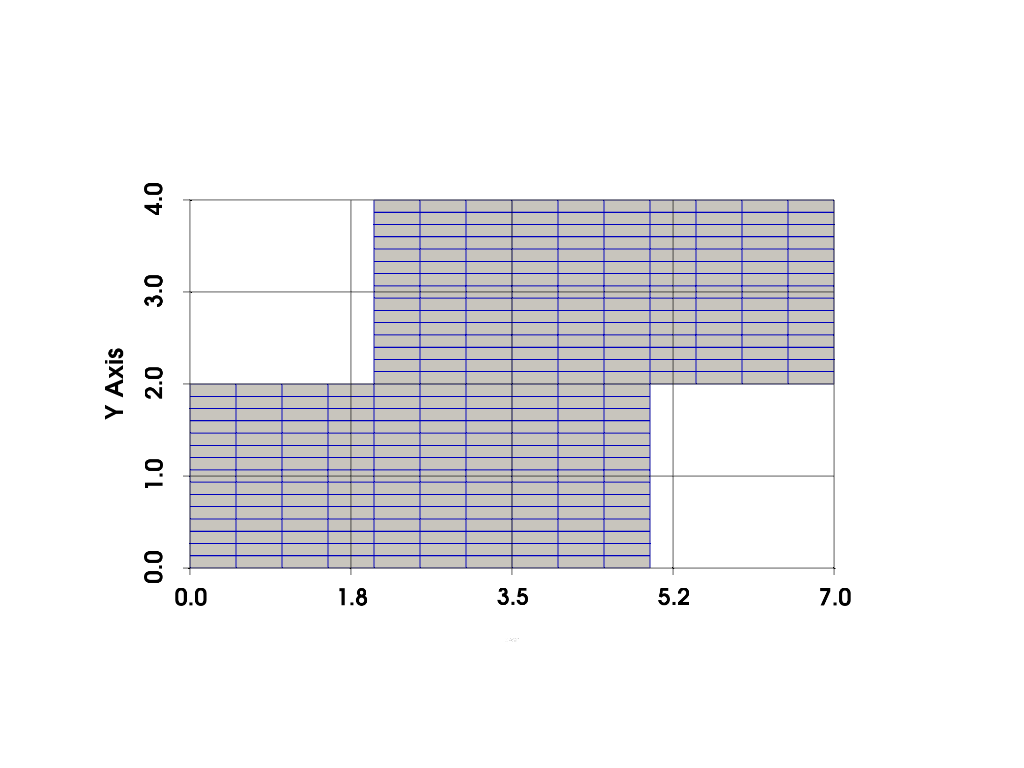

In [33]:
n = 10
z = 15

ps = []
rs = []

for m in range(len(rectangles)):
    xs = np.linspace(points[rectangles[m][0]][0], points[rectangles[m][1]][0], n+1)
    ys = np.linspace(points[rectangles[m][0]][1], points[rectangles[m][2]][1], z+1)
    for j in range(z+1):
        for i in range(n+1):
            ps.append([xs[i], ys[j]])
            
            if (j == z)|(i == n):
                pass
            else:
                n1 = (j*n + j + i) + m*(n+1)*(z+1)
                n2 = n1 + 1
                n3 = n2+n+1
                n4 = n3-1
                rs.append([n1, n2, n3, n4]) 

cells = [("quad", rs)]
mesh = meshio.Mesh(ps, cells)

mesh_pv = pv.wrap(mesh)

pl2 = pv.Plotter()
pl2.add_mesh(mesh_pv, color='white')
pl2.add_mesh(mesh_pv, color="blue", style='wireframe', line_width=1.5)
pl2.view_xy()
pl2.show_grid()
pl2.show(jupyter_backend='pythreejs')

Seguidamente se procede a realizar una integración con el método de cuadraturas gaussianas para cada rectangulo para posteriormente sumar cada resultado y hallar el valor de la integral requerida.

In [34]:
fun = lambda x, y: np.sin(np.pi*x)*np.cos(np.pi*y)**2

integral = 0

nx = 3
ny = 3

for i in range(len(rs)):
    p0 = ps[rs[i][0]]
    p1 = ps[rs[i][1]]
    p2 = ps[rs[i][2]]
    p3 = ps[rs[i][3]]

    integral_num = gaussian_integration_2D(p0, p1, p2, p3, fun, nx, ny)
    
    integral += integral_num
    
errorR = (round(100*abs(integral-analyticalIntegral)/analyticalIntegral,3))
print("Integral numérica: ", integral)
print(f"Error relativo: {errorR} %")

Integral numérica:  1.273249885420789
Error relativo: 0.001 %
